In [49]:
#drive에 마운트

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# Unet repository cloning

! pip -qq install git+https://github.com/qubvel/segmentation_models.pytorch

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [51]:
import segmentation_models_pytorch as smp
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import albumentations as A
import torch.nn.functional as F
import pandas as pd
import nibabel as nib #NII FILE 여는 라이브러리
from tqdm import tqdm#진행률 프로세스 바

# 파이선 버전 변경되어 import 필요
from segmentation_models_pytorch import utils

In [52]:
#image 위치 설정
imgpath = '/content/drive/MyDrive/2DUNET/dataset'

Text(0.5, 1.0, 'Segmentation Mask')

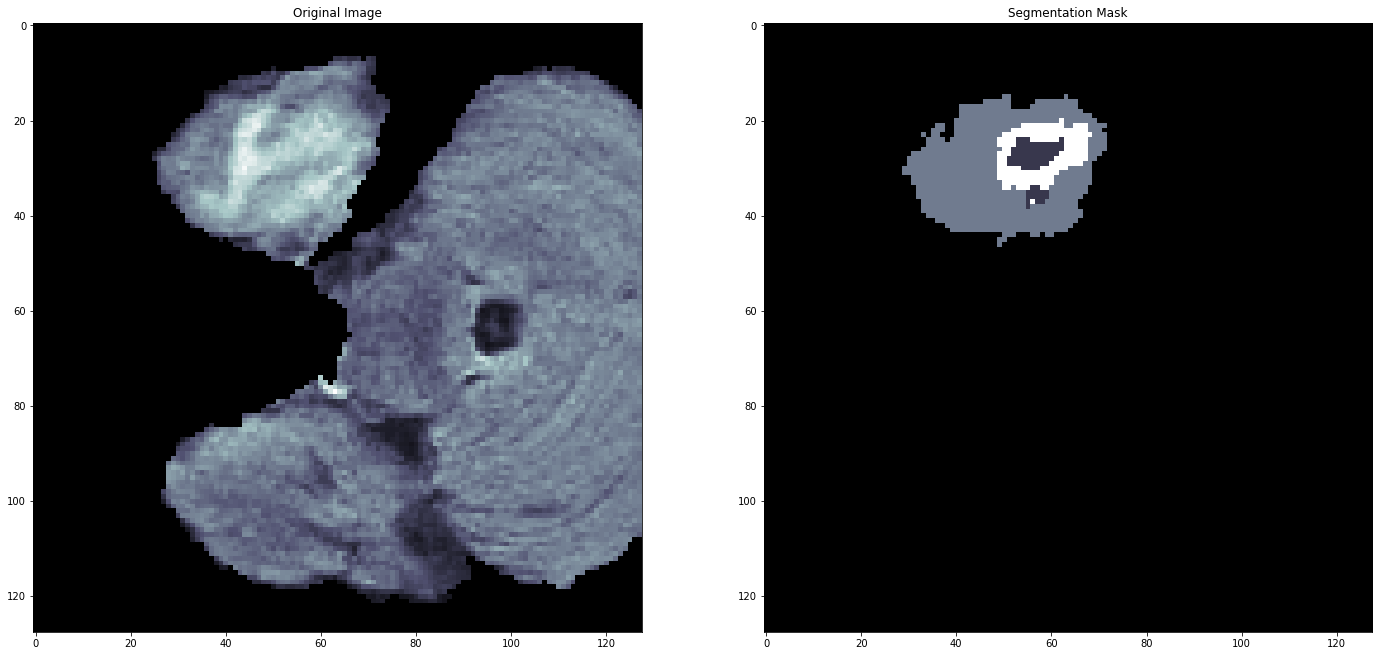

In [53]:
#sample image

fig = plt.figure(figsize = (24, 15))

plt.subplot(1, 2, 1)
plt.imshow(np.load(imgpath + '/flair/img_12.npy'), cmap = 'bone')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(np.load(imgpath + '/seg/img_12.npy'), cmap = 'bone')
plt.title('Segmentation Mask')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
tensor([0, 1])


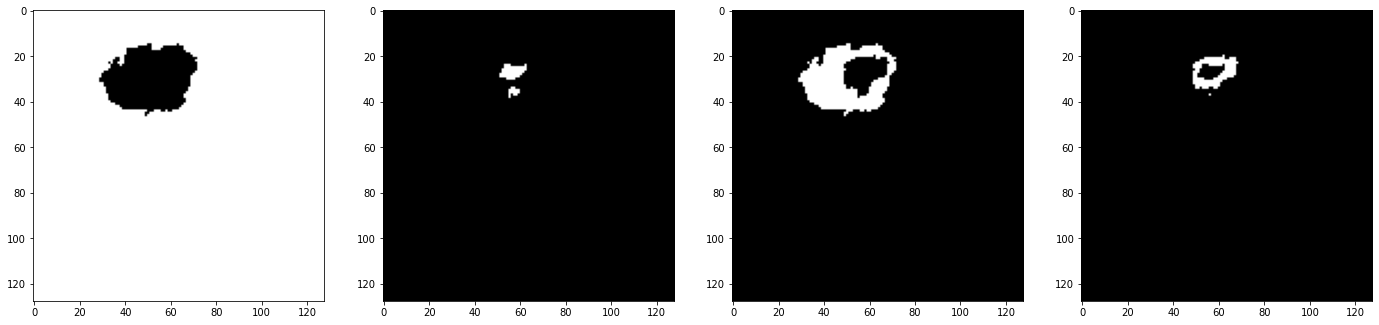

In [54]:
img = np.load(imgpath + '/seg/img_12.npy')
print(img)
images = {}
#images['mask'] = img
#images['mask'][images['mask'] == 4] = 3
img[img==4]  = 3 # 원하는 원소의 값을 바꾸어줌
#print(np.unique(img))
img = torch.from_numpy(img)
img = F.one_hot(img.long().unsqueeze(0), num_classes = 4).permute(0, 3, 1, 2).contiguous().squeeze(0)
img = img.long()

fig = plt.figure(figsize = (24, 15))


plt.subplot(1, 4, 1)
plt.imshow(img[0],cmap='gray')


plt.subplot(1, 4, 2)
plt.imshow(img[1],cmap='gray')


plt.subplot(1, 4, 3)
plt.imshow(img[2],cmap='gray')


plt.subplot(1, 4, 4)
plt.imshow(img[3],cmap='gray')

print(torch.unique(img[3]))

In [55]:
class Dataset(Dataset):
  def __init__(self, datapath = imgpath):
       self.folderpaths = {
                              'mask': os.path.join(datapath, 'seg/'),
                              't1': os.path.join(datapath, 't1/'),
                              't1ce': os.path.join(datapath, 't1ce/'),
                              't2': os.path.join(datapath, 't2/'),
                              'flair': os.path.join(datapath, 'flair/')
                          }
  def __getitem__(self, idx):
    images = {}
    for name in self.folderpaths:
      images[name] = np.load(os.path.join(self.folderpaths[name], f'img_{idx}.npy'))
    
    for name in images:
      images[name] = torch.from_numpy(images[name])
    
    input = torch.stack(
          
                                [images['t1'],
                                images['t1ce'],
                                images['t2'],
                                images['flair']], dim = 0
                        )
    images['mask'][images['mask'] == 4] = 3
        # one-hot encoding truth label
    images['mask'] = F.one_hot(images['mask'].long().unsqueeze(0), num_classes = 4).permute(0, 3, 1, 2).contiguous().squeeze(0)
    return input.float(), images['mask'].long()
    
    
  def __len__(self):
      return len(os.listdir(self.folderpaths['mask'])) - 1
  


In [56]:
train_dataset = Dataset(datapath = imgpath)

In [57]:
valid_test_dataset = Dataset(datapath = imgpath)
train_dataset = Dataset(datapath = imgpath)

train_length=int(0.6 * len(valid_test_dataset))
valid_length = int(0.2 * len(valid_test_dataset))
test_length = len(valid_test_dataset) - train_length - valid_length

_ , valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))#랜덤하게 데이터분할
train_dataset, _ , _ = torch.utils.data.random_split(train_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))

In [58]:
train_loader = DataLoader(train_dataset,#여기서 오류 발생, train feature와 train lable 반환
                      batch_size=16,
                      num_workers=2,
                      shuffle=True)

valid_loader = DataLoader(valid_dataset,
                      batch_size=1,
                      num_workers=2,
                      shuffle=False)

test_loader = DataLoader(test_dataset,
                      batch_size=1,
                      num_workers=2,
                      shuffle=False)

In [59]:
# a는 16장의 dim = 4 인 128*128 image
a, b = next(iter(train_loader))


torch.Size([128, 128])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])


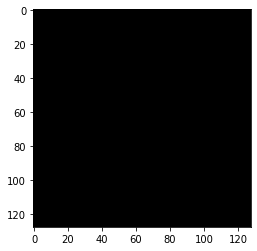

In [60]:
print(b[15, 0].shape)
plt.imshow(b[15, 3],cmap='gray')
print(b[15, 0])
#plt.imshow(b[15, 0],cmap='gray')

In [61]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Fri Dec  9 13:18:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   27C    P0    50W / 400W |   3030MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [62]:
MODEL = smp.PSPnet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    decoder_use_batchnorm=True,
    in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

AttributeError: ignored

In [ ]:
backgroundchannel = [0]

DICE_LOSS = smp.utils.losses.DiceLoss(activation = 'softmax2d')  

OPTIMIZER = torch.optim.Adam([ 
                                dict(params=MODEL.parameters(), lr = 0.0001),
                             ])
METRICS = [
              smp.utils.metrics.IoU(threshold = 0.5,ignore_channels = backgroundchannel, activation = 'softmax2d'),
              smp.utils.metrics.Fscore(ignore_channels = backgroundchannel, activation = 'softmax2d'),
          ]

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
                                            model = MODEL,
                                            loss = DICE_LOSS,
                                            metrics = [],
                                            optimizer = OPTIMIZER,
                                            device = DEVICE,
                                            verbose = True
                                        )
valid_epoch = smp.utils.train.ValidEpoch(
                                            model = MODEL,
                                            loss = DICE_LOSS,
                                            metrics = METRICS,
                                            device = DEVICE,
                                            verbose = True
                                        )

max_dice_score = 0
stats = {
          'train_loss' : [],
          'valid_loss' : [],
          'fscore' : [],
          'iou_score' : []
        }

for i in range(50):
  print(f'\n --- Epoch {i} --- ')
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(valid_loader)
  
  if max_dice_score < valid_logs['fscore']:
      max_dice_score = valid_logs['fscore']
      torch.save(MODEL.state_dict(), f'./model.pth')
      print('model saved!')
  
  # loss statistics
  stats['train_loss'].append(train_logs['dice_loss'])
  stats['valid_loss'].append(valid_logs['dice_loss'])

  # metric statistics
  stats['fscore'].append(valid_logs['fscore'])
  stats['iou_score'].append(valid_logs['iou_score'])
  np.save(f'./model.npy', stats)
  

In [ ]:
STATS = np.load(f'./model.npy', allow_pickle = 'TRUE').item()
plt.plot(STATS['train_loss'], label = 'train loss')
plt.plot(STATS['valid_loss'], label = 'valid loss')
plt.legend(loc = 'upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train and Validation Loss')

In [ ]:
STATS = np.load(f'./model.npy', allow_pickle = 'TRUE').item()
plt.plot(STATS['fscore'], label = 'fscore')
plt.legend(loc = "lower right")
plt.ylabel('score')
plt.xlabel('epoch')
plt.title('Fscore')

In [ ]:
MODEL.load_state_dict(torch.load('./model.pth'))

In [ ]:
with torch.no_grad():
    out = MODEL(a.cuda())

In [ ]:
plt.figure(figsize = (18, 10))
plt.subplot(1, 3, 1)
plt.imshow(a[2, 0],cmap='bone')
plt.title('Input Image')
plt.subplot(1, 3, 2)
plt.imshow(a[2, 0],cmap='bone')
plt.imshow(out.cpu()[2, 0], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Predicted Segmentation')

plt.subplot(1, 3, 3)
plt.imshow(out.cpu()[2, 0], cmap = 'bone')
plt.title('1')


In [ ]:
plt.figure(figsize = (18, 10))
plt.subplot(1, 4, 1)
plt.imshow(b[2, 0],cmap='gray')
plt.title('1')

plt.subplot(1, 4, 2)
plt.imshow(b[2, 1],cmap='gray')
plt.title('2')

plt.subplot(1, 4, 3)
plt.imshow(b[2, 2], cmap = 'gray')
plt.title('3')


plt.subplot(1, 4, 4)
plt.imshow(b[2, 3], cmap = 'gray')
plt.title('4')

In [ ]:
plt.figure(figsize = (18, 10))
plt.subplot(1, 4, 1)
plt.imshow(out.cpu()[2, 0],cmap='gray')
plt.title('1')

plt.subplot(1, 4, 2)
plt.imshow(out.cpu()[2, 1],cmap='gray')
plt.title('2')

plt.subplot(1, 4, 3)
plt.imshow(out.cpu()[2, 2], cmap = 'gray')
plt.title('3')


plt.subplot(1, 4, 4)
plt.imshow(out.cpu()[2, 3], cmap = 'gray')
plt.title('4')

